# 데이터 준비

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, Reshape
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback

import gc

In [2]:
dataset = tf.keras.datasets.mnist
# dataset = tf.keras.datasets.fashion_mnist
(train_images, _), (test_images, _) = dataset.load_data()

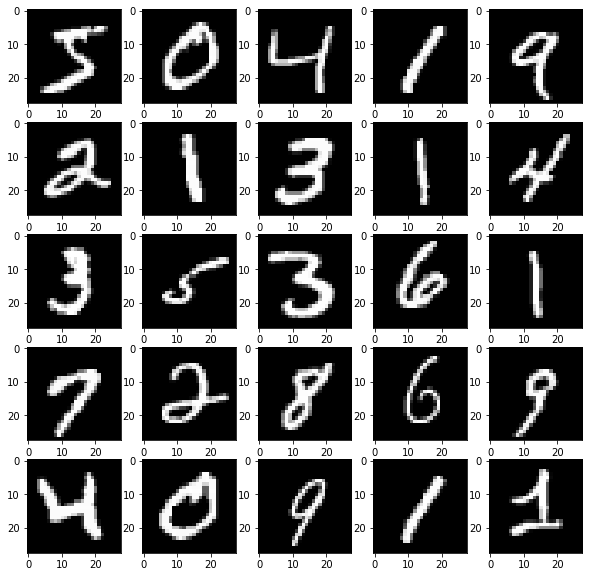

In [3]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_images[i], cmap="gray")

plt.show()


In [4]:
# IMAGE_SHAPE = (128, 128, 3)
IMAGE_SHAPE = (32, 32, 3)

def preprocess(images):
    if images.shape[1:3] != IMAGE_SHAPE:
        import cv2
        def resize(image):
            return cv2.resize(image, IMAGE_SHAPE[:2]) #28,28 -> 32,32
        images = np.array([resize(image) for image in images])
    if len(images.shape)!=4:
        images = np.stack((images,)*IMAGE_SHAPE[-1], axis=-1) #32,32 -> 32,32,3

    images = images.astype(np.float32)
    maxs = np.max(images)
    mins = np.min(images)
    images = (images - mins) / (maxs-mins)
    return images

train_images = preprocess(train_images)
test_images = preprocess(test_images)


In [5]:
train_images = train_images[:10000]

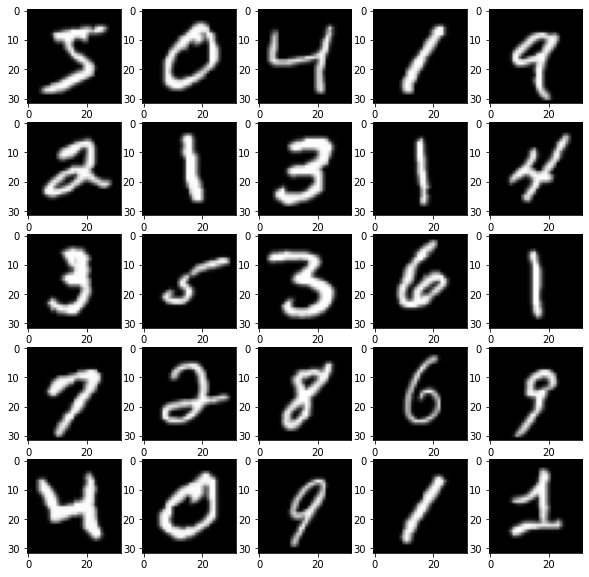

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_images[i])

plt.show()

In [7]:
HALF_IMAGE_SHAPE = (IMAGE_SHAPE[0], IMAGE_SHAPE[1]//2, IMAGE_SHAPE[2])
print(HALF_IMAGE_SHAPE)
BATCH_SIZE = 64

(32, 16, 3)


# D 정의

In [8]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, Reshape
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

In [9]:
def conv_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    activation = LeakyReLU(0.2),
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_discriminator_model():

    layer_filters = [32,64,128,256]

    condition_input = Input(shape=HALF_IMAGE_SHAPE, name="D_condition_input") #32,16,3 input 
    x = condition_input
    x = conv_block(x,  32, (5, 5), use_dropout=False)
    x = BatchNormalization()(x)
    x = conv_block(x, 64, (5, 5), use_dropout=False)
    x = BatchNormalization()(x)
    x = conv_block(x, 128, (5, 5), use_dropout=False)
    x = BatchNormalization()(x)
    x = conv_block(x, 256, (5, 5), use_dropout=False)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    condition_out = x
    
    img_input = Input(shape=HALF_IMAGE_SHAPE, name="D_image_input")
    tt = img_input
    tt = conv_block(tt,  64, (5, 5), use_dropout=False)    
    tt = conv_block(tt, 128, (5, 5), use_dropout=True)    
    tt = conv_block(tt, 256, (5, 5), use_dropout=True)  
    tt = conv_block(tt, 512, (5, 5), use_dropout=False)    
    tt = Flatten()(tt)
    tt = Dropout(0.2)(tt)
    img_out = tt

    x = tf.concat([img_out, condition_out], axis=-1)
    x = Dense(32, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    output = x

    d_model = keras.models.Model([condition_input, img_input], output, name="discriminator")
    return d_model

d_model = get_discriminator_model()
d_model.summary()


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 D_image_input (InputLayer)     [(None, 32, 16, 3)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 16, 8, 64)    4864        ['D_image_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        multiple             0           ['conv2d[0][0]',                 
                                                                  'conv2d_1[0][0]',               
                                                                  'conv2d_2[0][0]',               
                                                                  'conv2d_3[0][0]',   

# G 정의


In [14]:
LATENT_DIM = 128
def upsample_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    activation = LeakyReLU(0.2),
    use_bn=True,
    use_bias=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = UpSampling2D(up_size)(x)
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = BatchNormalization()(x)
    if activation:
        x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_generator_model():

    condition_input = Input(shape=HALF_IMAGE_SHAPE, name="G_condition_input")
    x = condition_input
    x = conv_block(x,  64, (5, 5), use_dropout=False)
    x = BatchNormalization()(x)
    x = conv_block(x, 128, (5, 5), use_dropout=True)
    x = BatchNormalization()(x)
    x = conv_block(x, 256, (5, 5), use_dropout=True)
    x = BatchNormalization()(x)
    x = conv_block(x, 512, (5, 5), use_dropout=False)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    condition_out = x

    latent = Input(shape=(LATENT_DIM,), name="G_latent_input")
    tt = tf.concat([condition_out, latent], axis=-1)
    tt = Dense(4 * 2 * 256, use_bias=False)(tt)
    tt = BatchNormalization()(tt)
    tt = LeakyReLU(0.2)(tt)
    tt = Reshape((4, 2, 256))(tt)
    tt = upsample_block(tt, 128, )
    tt = upsample_block(tt,  64, )
    tt = upsample_block(tt,   3, activation=Activation("sigmoid"))
    # tt = Dropout(0.2)(tt)
    output = tt

    g_model = keras.models.Model([condition_input, latent], output, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 G_condition_input (InputLayer)  [(None, 32, 16, 3)]  0          []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 16, 8, 64)    4864        ['G_condition_input[0][0]']      
                                                                                                  
 leaky_re_lu (LeakyReLU)        multiple             0           ['conv2d_8[0][0]',               
                                                                  'conv2d_9[0][0]',               
                                                                  'conv2d_10[0][0]',              
                                                                  'conv2d_11[0][0]']      

# WGAN-GP 모델 정의

In [15]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, conditions, real_images, fake_images):
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator([conditions, interpolated], training=True)

        grads = gp_tape.gradient(pred, [conditions, interpolated])[1]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        HALF_SIZE = HALF_IMAGE_SHAPE[1]
        conditions = real_images[:,:,:HALF_SIZE,:]
        half_images = real_images[:,:,HALF_SIZE:,:]


        # D 학습

        # D는 G에 비해 d_steps 배 학습함.
        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                fake_images = self.generator([conditions, random_latent_vectors], training=True)
                fake_logits = self.discriminator([conditions, fake_images], training=True)
                real_logits = self.discriminator([conditions, half_images], training=True)

                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                gp = self.gradient_penalty(batch_size, conditions, half_images, fake_images)
                d_loss = d_cost + gp * self.gp_weight
                
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        # G 학습
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator([conditions, random_latent_vectors], training=True)
            gen_img_logits = self.discriminator([conditions, generated_images], training=True)
            g_loss = self.g_loss_fn(gen_img_logits)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        # return {"d_loss": d_loss, "g_loss": g_loss}
        return {"d_loss": d_loss, "g_loss": g_loss, "gp":gp, "d_cost":d_cost}        

# 에폭 마다 결과 보는 callback

In [16]:
import matplotlib.pyplot as plt

class GANMonitor(Callback):
    def __init__(self, images, latent_dim=LATENT_DIM):
        self.num_img = len(images)
        self.images = images
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        print("epoch",epoch)
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        conditions = self.images[:,:,:HALF_IMAGE_SHAPE[1],:]
        generated_images = self.model.generator([conditions, random_latent_vectors])

        full_images = self.images.copy()
        full_images[:,:,HALF_IMAGE_SHAPE[1]:,:] = generated_images

        plt.figure(figsize=(10, 3))
        for i in range(1, self.num_img):
            ax = plt.subplot(1, self.num_img, i)
            plt.imshow(full_images[i-1], cmap="binary")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

        # for i in range(self.num_img):
        #     img = generated_images[i].numpy()
        #     img = keras.preprocessing.image.array_to_img(img)
        #     img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))



# 학습


## BatchNormalization Layer 추가 
- Conv Block 및 모든 레이어 사이에 BatchNormalization Layer 추가 

Epoch 1/100
157/157 [==============================] - ETA: 0s - d_loss: 9.8956 - g_loss: -0.5052 - gp: 0.9895 - d_cost: 8.6121e-04epoch 0


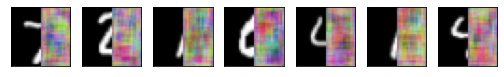

157/157 [==============================] - 50s 181ms/step - d_loss: 9.8954 - g_loss: -0.5052 - gp: 0.9895 - d_cost: 6.3692e-04
Epoch 2/100
157/157 [==============================] - ETA: 0s - d_loss: 9.8950 - g_loss: -0.5069 - gp: 0.9895 - d_cost: 3.6351e-04epoch 1


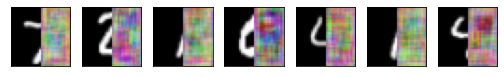

157/157 [==============================] - 28s 180ms/step - d_loss: 9.8952 - g_loss: -0.5070 - gp: 0.9895 - d_cost: 5.0056e-04
Epoch 3/100
157/157 [==============================] - ETA: 0s - d_loss: 9.8949 - g_loss: -0.5052 - gp: 0.9894 - d_cost: 6.6469e-04epoch 2


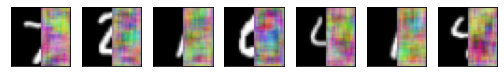

157/157 [==============================] - 28s 180ms/step - d_loss: 9.8950 - g_loss: -0.5052 - gp: 0.9894 - d_cost: 7.6418e-04
Epoch 4/100
157/157 [==============================] - ETA: 0s - d_loss: 9.8929 - g_loss: -0.5049 - gp: 0.9894 - d_cost: -9.3579e-04epoch 3


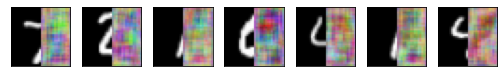

157/157 [==============================] - 28s 180ms/step - d_loss: 9.8930 - g_loss: -0.5049 - gp: 0.9894 - d_cost: -8.5744e-04
Epoch 5/100
157/157 [==============================] - ETA: 0s - d_loss: 9.8931 - g_loss: -0.5041 - gp: 0.9893 - d_cost: 8.7171e-05epoch 4


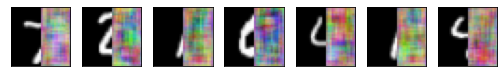

157/157 [==============================] - 28s 180ms/step - d_loss: 9.8931 - g_loss: -0.5041 - gp: 0.9893 - d_cost: 1.0694e-04
Epoch 6/100
157/157 [==============================] - ETA: 0s - d_loss: 9.8918 - g_loss: -0.5035 - gp: 0.9893 - d_cost: -0.0012epoch 5


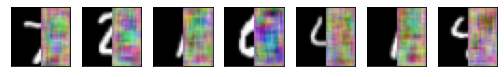

157/157 [==============================] - 28s 180ms/step - d_loss: 9.8919 - g_loss: -0.5037 - gp: 0.9893 - d_cost: -0.0012
Epoch 7/100
157/157 [==============================] - ETA: 0s - d_loss: 9.8915 - g_loss: -0.5037 - gp: 0.9893 - d_cost: -0.0013epoch 6


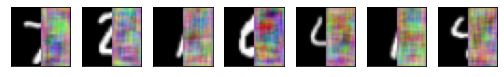

157/157 [==============================] - 28s 180ms/step - d_loss: 9.8914 - g_loss: -0.5036 - gp: 0.9893 - d_cost: -0.0014
Epoch 8/100
157/157 [==============================] - ETA: 0s - d_loss: 9.8899 - g_loss: -0.5036 - gp: 0.9892 - d_cost: -0.0025epoch 7


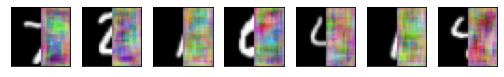

157/157 [==============================] - 28s 181ms/step - d_loss: 9.8899 - g_loss: -0.5035 - gp: 0.9892 - d_cost: -0.0025
Epoch 9/100
157/157 [==============================] - ETA: 0s - d_loss: 9.8916 - g_loss: -0.5038 - gp: 0.9892 - d_cost: -3.0594e-04epoch 8


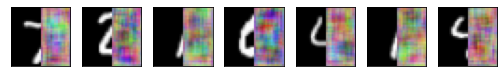

157/157 [==============================] - 28s 180ms/step - d_loss: 9.8918 - g_loss: -0.5037 - gp: 0.9892 - d_cost: -1.0267e-04
Epoch 10/100
157/157 [==============================] - ETA: 0s - d_loss: 9.8904 - g_loss: -0.5041 - gp: 0.9891 - d_cost: -0.0011epoch 9


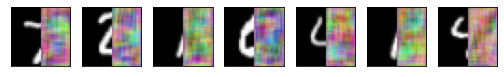

157/157 [==============================] - 28s 180ms/step - d_loss: 9.8905 - g_loss: -0.5040 - gp: 0.9891 - d_cost: -9.8397e-04
Epoch 11/100
157/157 [==============================] - ETA: 0s - d_loss: 9.8900 - g_loss: -0.5021 - gp: 0.9891 - d_cost: -0.0013epoch 10


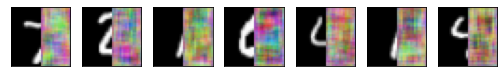

157/157 [==============================] - 28s 180ms/step - d_loss: 9.8900 - g_loss: -0.5021 - gp: 0.9891 - d_cost: -0.0013
Epoch 12/100
157/157 [==============================] - ETA: 0s - d_loss: 9.8889 - g_loss: -0.5035 - gp: 0.9891 - d_cost: -0.0019epoch 11


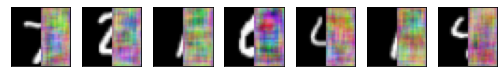

157/157 [==============================] - 28s 180ms/step - d_loss: 9.8889 - g_loss: -0.5035 - gp: 0.9891 - d_cost: -0.0019
Epoch 13/100
157/157 [==============================] - ETA: 0s - d_loss: 9.8879 - g_loss: -0.5026 - gp: 0.9890 - d_cost: -0.0023epoch 12


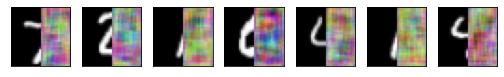

157/157 [==============================] - 28s 180ms/step - d_loss: 9.8877 - g_loss: -0.5025 - gp: 0.9890 - d_cost: -0.0025
Epoch 14/100
157/157 [==============================] - ETA: 0s - d_loss: 9.8872 - g_loss: -0.5014 - gp: 0.9890 - d_cost: -0.0026epoch 13


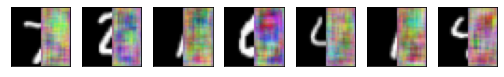

157/157 [==============================] - 28s 180ms/step - d_loss: 9.8872 - g_loss: -0.5012 - gp: 0.9890 - d_cost: -0.0026
Epoch 15/100
157/157 [==============================] - ETA: 0s - d_loss: 9.8858 - g_loss: -0.5016 - gp: 0.9889 - d_cost: -0.0035epoch 14


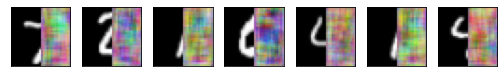

157/157 [==============================] - 28s 180ms/step - d_loss: 9.8858 - g_loss: -0.5015 - gp: 0.9889 - d_cost: -0.0035
Epoch 16/100
  6/157 [>.............................] - ETA: 27s - d_loss: 9.8848 - g_loss: -0.5031 - gp: 0.9889 - d_cost: -0.0045

In [ ]:
# generator_optimizer = Adam(learning_rate=0.0002*0.1, beta_1=0.5, beta_2=0.9)
# discriminator_optimizer = Adam(learning_rate=0.0002*0.1, beta_1=0.5, beta_2=0.9)
from tensorflow.keras.optimizers import RMSprop
generator_optimizer = RMSprop(learning_rate=0.0001*0.0001)
discriminator_optimizer = RMSprop(learning_rate=0.0001*0.0001)


def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean((real_img+(1e-9)))
    fake_loss = tf.reduce_mean((fake_img+(1e-9)))
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

g_model = get_generator_model()
d_model = get_discriminator_model()

wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=LATENT_DIM,
    discriminator_extra_steps=3,
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

cbk = GANMonitor(test_images[:8])
history = wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=100, callbacks=[cbk])
wgan.fit(train_images[:1000], batch_size=BATCH_SIZE, epochs=2, callbacks=[cbk])


## 3. Conv Block use_bn 옵션 True
- 별개의 BatchNormalization layer는 추가하지 않음

Epoch 1/100
157/157 [==============================] - ETA: 0s - d_loss: 2.5427 - g_loss: -0.5575 - gp: 0.2558 - d_cost: -0.0158epoch 0


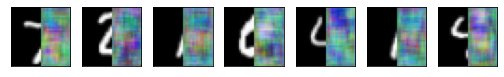

157/157 [==============================] - 54s 189ms/step - d_loss: 2.5415 - g_loss: -0.5575 - gp: 0.2557 - d_cost: -0.0157
Epoch 2/100
157/157 [==============================] - ETA: 0s - d_loss: 2.4987 - g_loss: -0.5487 - gp: 0.2516 - d_cost: -0.0177epoch 1


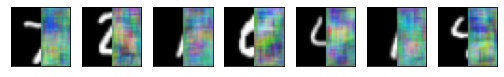

157/157 [==============================] - 30s 190ms/step - d_loss: 2.5009 - g_loss: -0.5488 - gp: 0.2518 - d_cost: -0.0175
Epoch 3/100
157/157 [==============================] - ETA: 0s - d_loss: 2.4658 - g_loss: -0.5460 - gp: 0.2483 - d_cost: -0.0168epoch 2


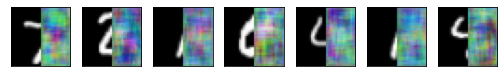

157/157 [==============================] - 30s 189ms/step - d_loss: 2.4641 - g_loss: -0.5458 - gp: 0.2482 - d_cost: -0.0174
Epoch 4/100
157/157 [==============================] - ETA: 0s - d_loss: 2.4488 - g_loss: -0.5408 - gp: 0.2463 - d_cost: -0.0145epoch 3


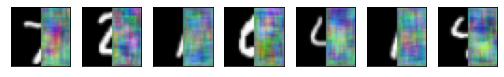

157/157 [==============================] - 30s 189ms/step - d_loss: 2.4539 - g_loss: -0.5406 - gp: 0.2468 - d_cost: -0.0138
Epoch 5/100
157/157 [==============================] - ETA: 0s - d_loss: 2.4427 - g_loss: -0.5359 - gp: 0.2459 - d_cost: -0.0165epoch 4


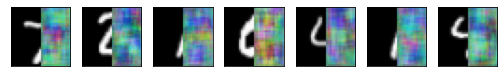

157/157 [==============================] - 30s 190ms/step - d_loss: 2.4336 - g_loss: -0.5359 - gp: 0.2450 - d_cost: -0.0162
Epoch 6/100
157/157 [==============================] - ETA: 0s - d_loss: 2.4420 - g_loss: -0.5316 - gp: 0.2460 - d_cost: -0.0176epoch 5


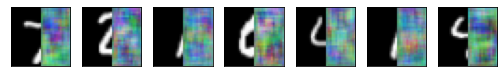

157/157 [==============================] - 30s 190ms/step - d_loss: 2.4455 - g_loss: -0.5315 - gp: 0.2463 - d_cost: -0.0170
Epoch 7/100
157/157 [==============================] - ETA: 0s - d_loss: 2.3425 - g_loss: -0.5242 - gp: 0.2363 - d_cost: -0.0202epoch 6


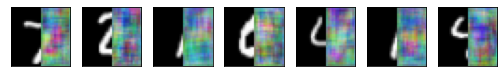

157/157 [==============================] - 30s 191ms/step - d_loss: 2.3364 - g_loss: -0.5244 - gp: 0.2356 - d_cost: -0.0200
Epoch 8/100
157/157 [==============================] - ETA: 0s - d_loss: 2.4275 - g_loss: -0.5229 - gp: 0.2450 - d_cost: -0.0227epoch 7


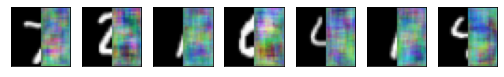

157/157 [==============================] - 30s 190ms/step - d_loss: 2.4155 - g_loss: -0.5233 - gp: 0.2438 - d_cost: -0.0227
Epoch 9/100
157/157 [==============================] - ETA: 0s - d_loss: 2.3689 - g_loss: -0.5204 - gp: 0.2391 - d_cost: -0.0221epoch 8


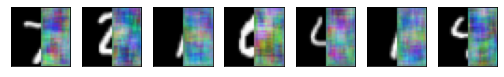

157/157 [==============================] - 30s 190ms/step - d_loss: 2.3634 - g_loss: -0.5208 - gp: 0.2386 - d_cost: -0.0221
Epoch 10/100
157/157 [==============================] - ETA: 0s - d_loss: 2.3796 - g_loss: -0.5192 - gp: 0.2403 - d_cost: -0.0231epoch 9


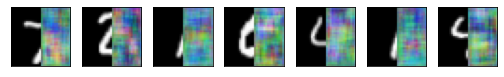

157/157 [==============================] - 30s 191ms/step - d_loss: 2.3739 - g_loss: -0.5192 - gp: 0.2397 - d_cost: -0.0235
Epoch 11/100
157/157 [==============================] - ETA: 0s - d_loss: 2.3927 - g_loss: -0.5160 - gp: 0.2416 - d_cost: -0.0236epoch 10


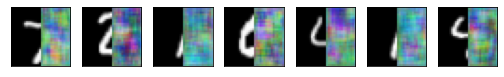

157/157 [==============================] - 30s 190ms/step - d_loss: 2.3954 - g_loss: -0.5159 - gp: 0.2419 - d_cost: -0.0236
Epoch 12/100
157/157 [==============================] - ETA: 0s - d_loss: 2.3776 - g_loss: -0.5151 - gp: 0.2404 - d_cost: -0.0264epoch 11


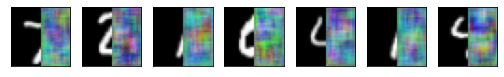

157/157 [==============================] - 30s 191ms/step - d_loss: 2.3770 - g_loss: -0.5149 - gp: 0.2403 - d_cost: -0.0261
Epoch 13/100
157/157 [==============================] - ETA: 0s - d_loss: 2.3739 - g_loss: -0.5089 - gp: 0.2402 - d_cost: -0.0278epoch 12


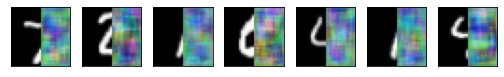

157/157 [==============================] - 30s 193ms/step - d_loss: 2.3678 - g_loss: -0.5088 - gp: 0.2396 - d_cost: -0.0281
Epoch 14/100
157/157 [==============================] - ETA: 0s - d_loss: 2.3830 - g_loss: -0.5100 - gp: 0.2410 - d_cost: -0.0267epoch 13


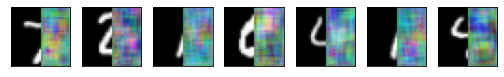

157/157 [==============================] - 30s 191ms/step - d_loss: 2.3781 - g_loss: -0.5098 - gp: 0.2405 - d_cost: -0.0267
Epoch 15/100
157/157 [==============================] - ETA: 0s - d_loss: 2.3216 - g_loss: -0.5084 - gp: 0.2350 - d_cost: -0.0288epoch 14


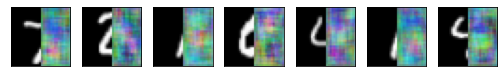

157/157 [==============================] - 30s 191ms/step - d_loss: 2.3169 - g_loss: -0.5086 - gp: 0.2345 - d_cost: -0.0279
Epoch 16/100
157/157 [==============================] - ETA: 0s - d_loss: 2.3322 - g_loss: -0.5070 - gp: 0.2364 - d_cost: -0.0314epoch 15


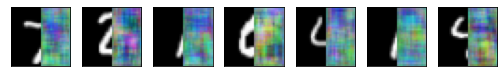

157/157 [==============================] - 30s 192ms/step - d_loss: 2.3382 - g_loss: -0.5070 - gp: 0.2370 - d_cost: -0.0315
Epoch 17/100
157/157 [==============================] - ETA: 0s - d_loss: 2.3517 - g_loss: -0.5028 - gp: 0.2382 - d_cost: -0.0308epoch 16


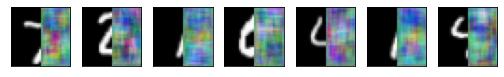

157/157 [==============================] - 30s 192ms/step - d_loss: 2.3501 - g_loss: -0.5027 - gp: 0.2381 - d_cost: -0.0308
Epoch 18/100
157/157 [==============================] - ETA: 0s - d_loss: 2.3269 - g_loss: -0.5019 - gp: 0.2359 - d_cost: -0.0323epoch 17


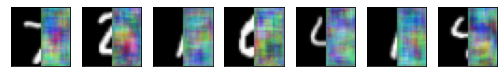

157/157 [==============================] - 30s 192ms/step - d_loss: 2.3303 - g_loss: -0.5017 - gp: 0.2363 - d_cost: -0.0326
Epoch 19/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2762 - g_loss: -0.5001 - gp: 0.2306 - d_cost: -0.0302epoch 18


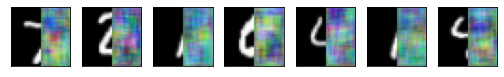

157/157 [==============================] - 30s 192ms/step - d_loss: 2.2704 - g_loss: -0.5001 - gp: 0.2300 - d_cost: -0.0301
Epoch 20/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2676 - g_loss: -0.4981 - gp: 0.2301 - d_cost: -0.0335epoch 19


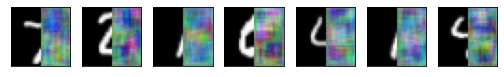

157/157 [==============================] - 30s 192ms/step - d_loss: 2.2557 - g_loss: -0.4981 - gp: 0.2289 - d_cost: -0.0336
Epoch 21/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2576 - g_loss: -0.4973 - gp: 0.2299 - d_cost: -0.0413epoch 20


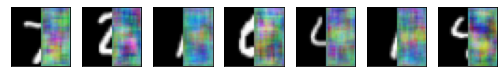

157/157 [==============================] - 30s 192ms/step - d_loss: 2.2606 - g_loss: -0.4975 - gp: 0.2302 - d_cost: -0.0414
Epoch 22/100
157/157 [==============================] - ETA: 0s - d_loss: 2.3161 - g_loss: -0.4990 - gp: 0.2355 - d_cost: -0.0391epoch 21


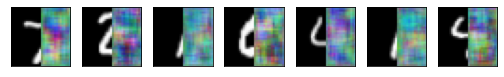

157/157 [==============================] - 30s 192ms/step - d_loss: 2.3151 - g_loss: -0.4990 - gp: 0.2354 - d_cost: -0.0393
Epoch 23/100
157/157 [==============================] - ETA: 0s - d_loss: 2.3149 - g_loss: -0.4943 - gp: 0.2356 - d_cost: -0.0415epoch 22


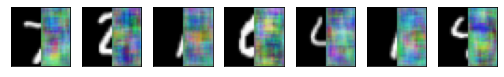

157/157 [==============================] - 30s 194ms/step - d_loss: 2.3137 - g_loss: -0.4941 - gp: 0.2355 - d_cost: -0.0415
Epoch 24/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2779 - g_loss: -0.4934 - gp: 0.2317 - d_cost: -0.0396epoch 23


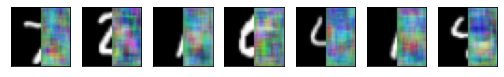

157/157 [==============================] - 30s 192ms/step - d_loss: 2.2770 - g_loss: -0.4935 - gp: 0.2316 - d_cost: -0.0395
Epoch 25/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2409 - g_loss: -0.4916 - gp: 0.2286 - d_cost: -0.0450epoch 24


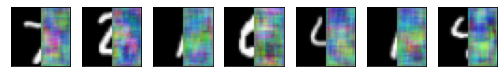

157/157 [==============================] - 30s 192ms/step - d_loss: 2.2312 - g_loss: -0.4914 - gp: 0.2276 - d_cost: -0.0451
Epoch 26/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2443 - g_loss: -0.4923 - gp: 0.2289 - d_cost: -0.0445epoch 25


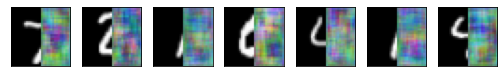

157/157 [==============================] - 30s 192ms/step - d_loss: 2.2439 - g_loss: -0.4922 - gp: 0.2288 - d_cost: -0.0443
Epoch 27/100
157/157 [==============================] - ETA: 0s - d_loss: 2.3002 - g_loss: -0.4911 - gp: 0.2345 - d_cost: -0.0449epoch 26


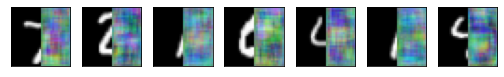

157/157 [==============================] - 30s 193ms/step - d_loss: 2.2969 - g_loss: -0.4911 - gp: 0.2342 - d_cost: -0.0455
Epoch 28/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2986 - g_loss: -0.4902 - gp: 0.2344 - d_cost: -0.0454epoch 27


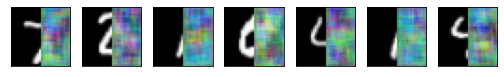

157/157 [==============================] - 30s 194ms/step - d_loss: 2.2956 - g_loss: -0.4900 - gp: 0.2341 - d_cost: -0.0454
Epoch 29/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2118 - g_loss: -0.4888 - gp: 0.2260 - d_cost: -0.0481epoch 28


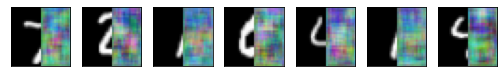

157/157 [==============================] - 30s 194ms/step - d_loss: 2.2038 - g_loss: -0.4887 - gp: 0.2251 - d_cost: -0.0475
Epoch 30/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2579 - g_loss: -0.4877 - gp: 0.2306 - d_cost: -0.0485epoch 29


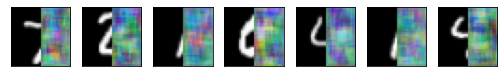

157/157 [==============================] - 30s 194ms/step - d_loss: 2.2512 - g_loss: -0.4880 - gp: 0.2300 - d_cost: -0.0489
Epoch 31/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2339 - g_loss: -0.4856 - gp: 0.2285 - d_cost: -0.0514epoch 30


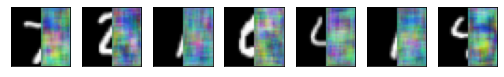

157/157 [==============================] - 30s 193ms/step - d_loss: 2.2378 - g_loss: -0.4853 - gp: 0.2289 - d_cost: -0.0514
Epoch 32/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2359 - g_loss: -0.4852 - gp: 0.2284 - d_cost: -0.0477epoch 31


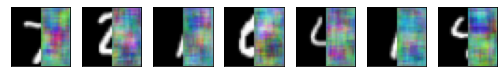

157/157 [==============================] - 30s 194ms/step - d_loss: 2.2274 - g_loss: -0.4851 - gp: 0.2275 - d_cost: -0.0481
Epoch 33/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2318 - g_loss: -0.4863 - gp: 0.2283 - d_cost: -0.0514epoch 32


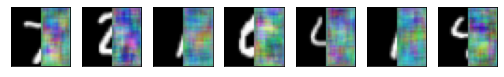

157/157 [==============================] - 30s 193ms/step - d_loss: 2.2338 - g_loss: -0.4864 - gp: 0.2285 - d_cost: -0.0512
Epoch 34/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2501 - g_loss: -0.4843 - gp: 0.2304 - d_cost: -0.0535epoch 33


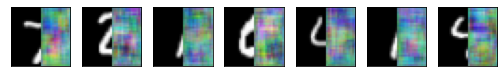

157/157 [==============================] - 31s 195ms/step - d_loss: 2.2415 - g_loss: -0.4843 - gp: 0.2295 - d_cost: -0.0536
Epoch 35/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2379 - g_loss: -0.4815 - gp: 0.2292 - d_cost: -0.0543epoch 34


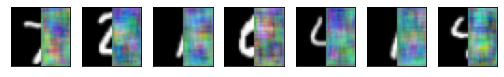

157/157 [==============================] - 30s 193ms/step - d_loss: 2.2300 - g_loss: -0.4815 - gp: 0.2284 - d_cost: -0.0541
Epoch 36/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2343 - g_loss: -0.4822 - gp: 0.2291 - d_cost: -0.0563epoch 35


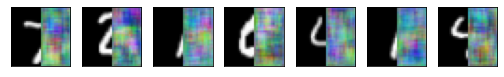

157/157 [==============================] - 30s 194ms/step - d_loss: 2.2287 - g_loss: -0.4821 - gp: 0.2285 - d_cost: -0.0563
Epoch 37/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1899 - g_loss: -0.4814 - gp: 0.2246 - d_cost: -0.0564epoch 36


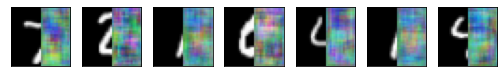

157/157 [==============================] - 30s 194ms/step - d_loss: 2.1916 - g_loss: -0.4814 - gp: 0.2248 - d_cost: -0.0562
Epoch 38/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2103 - g_loss: -0.4791 - gp: 0.2272 - d_cost: -0.0612epoch 37


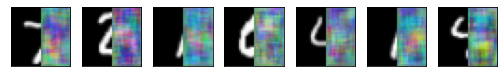

157/157 [==============================] - 30s 194ms/step - d_loss: 2.2018 - g_loss: -0.4790 - gp: 0.2263 - d_cost: -0.0610
Epoch 39/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2282 - g_loss: -0.4789 - gp: 0.2288 - d_cost: -0.0594epoch 38


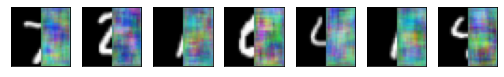

157/157 [==============================] - 30s 194ms/step - d_loss: 2.2302 - g_loss: -0.4789 - gp: 0.2290 - d_cost: -0.0595
Epoch 40/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1633 - g_loss: -0.4797 - gp: 0.2224 - d_cost: -0.0609epoch 39


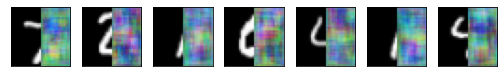

157/157 [==============================] - 30s 193ms/step - d_loss: 2.1622 - g_loss: -0.4800 - gp: 0.2223 - d_cost: -0.0611
Epoch 41/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1455 - g_loss: -0.4784 - gp: 0.2208 - d_cost: -0.0621epoch 40


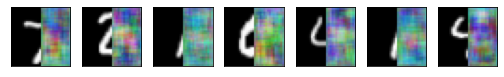

157/157 [==============================] - 30s 194ms/step - d_loss: 2.1440 - g_loss: -0.4781 - gp: 0.2206 - d_cost: -0.0619
Epoch 42/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2126 - g_loss: -0.4785 - gp: 0.2277 - d_cost: -0.0648epoch 41


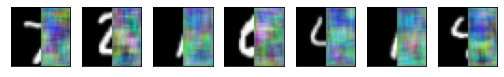

157/157 [==============================] - 30s 194ms/step - d_loss: 2.2129 - g_loss: -0.4789 - gp: 0.2278 - d_cost: -0.0650
Epoch 43/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2167 - g_loss: -0.4765 - gp: 0.2281 - d_cost: -0.0646epoch 42


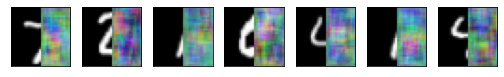

157/157 [==============================] - 30s 194ms/step - d_loss: 2.2109 - g_loss: -0.4764 - gp: 0.2276 - d_cost: -0.0650
Epoch 44/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1680 - g_loss: -0.4751 - gp: 0.2235 - d_cost: -0.0674epoch 43


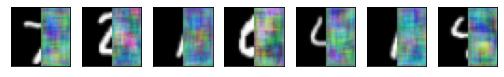

157/157 [==============================] - 31s 196ms/step - d_loss: 2.1623 - g_loss: -0.4755 - gp: 0.2230 - d_cost: -0.0676
Epoch 45/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2016 - g_loss: -0.4740 - gp: 0.2269 - d_cost: -0.0670epoch 44


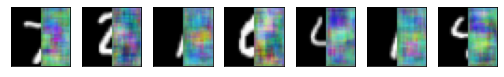

157/157 [==============================] - 31s 195ms/step - d_loss: 2.1967 - g_loss: -0.4740 - gp: 0.2264 - d_cost: -0.0669
Epoch 46/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2011 - g_loss: -0.4735 - gp: 0.2268 - d_cost: -0.0667epoch 45


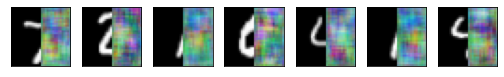

157/157 [==============================] - 30s 194ms/step - d_loss: 2.1957 - g_loss: -0.4733 - gp: 0.2262 - d_cost: -0.0663
Epoch 47/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1393 - g_loss: -0.4749 - gp: 0.2210 - d_cost: -0.0706epoch 46


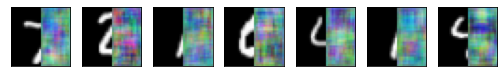

157/157 [==============================] - 30s 193ms/step - d_loss: 2.1403 - g_loss: -0.4751 - gp: 0.2211 - d_cost: -0.0704
Epoch 48/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1863 - g_loss: -0.4717 - gp: 0.2257 - d_cost: -0.0705epoch 47


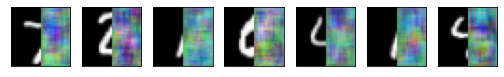

157/157 [==============================] - 31s 194ms/step - d_loss: 2.1755 - g_loss: -0.4716 - gp: 0.2246 - d_cost: -0.0707
Epoch 49/100
157/157 [==============================] - ETA: 0s - d_loss: 2.2006 - g_loss: -0.4730 - gp: 0.2271 - d_cost: -0.0700epoch 48


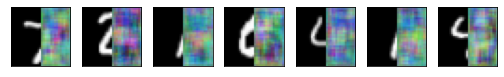

157/157 [==============================] - 30s 194ms/step - d_loss: 2.2036 - g_loss: -0.4733 - gp: 0.2273 - d_cost: -0.0698
Epoch 50/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1141 - g_loss: -0.4708 - gp: 0.2187 - d_cost: -0.0732epoch 49


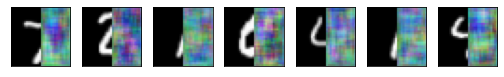

157/157 [==============================] - 30s 193ms/step - d_loss: 2.1085 - g_loss: -0.4707 - gp: 0.2182 - d_cost: -0.0735
Epoch 51/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1308 - g_loss: -0.4701 - gp: 0.2204 - d_cost: -0.0728epoch 50


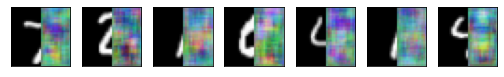

157/157 [==============================] - 30s 194ms/step - d_loss: 2.1361 - g_loss: -0.4702 - gp: 0.2209 - d_cost: -0.0726
Epoch 52/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1986 - g_loss: -0.4692 - gp: 0.2273 - d_cost: -0.0743epoch 51


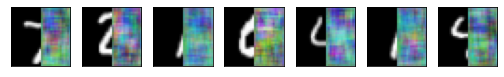

157/157 [==============================] - 30s 193ms/step - d_loss: 2.1959 - g_loss: -0.4691 - gp: 0.2269 - d_cost: -0.0736
Epoch 53/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1297 - g_loss: -0.4667 - gp: 0.2206 - d_cost: -0.0763epoch 52


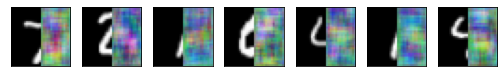

157/157 [==============================] - 30s 194ms/step - d_loss: 2.1223 - g_loss: -0.4671 - gp: 0.2199 - d_cost: -0.0762
Epoch 54/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1766 - g_loss: -0.4671 - gp: 0.2256 - d_cost: -0.0790epoch 53


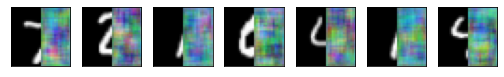

157/157 [==============================] - 30s 194ms/step - d_loss: 2.1722 - g_loss: -0.4672 - gp: 0.2251 - d_cost: -0.0789
Epoch 55/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1093 - g_loss: -0.4672 - gp: 0.2191 - d_cost: -0.0817epoch 54


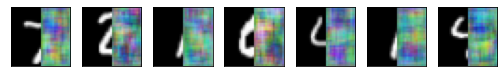

157/157 [==============================] - 31s 196ms/step - d_loss: 2.1085 - g_loss: -0.4673 - gp: 0.2190 - d_cost: -0.0816
Epoch 56/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1490 - g_loss: -0.4669 - gp: 0.2225 - d_cost: -0.0759epoch 55


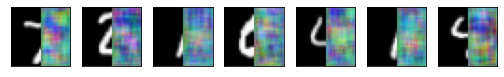

157/157 [==============================] - 30s 194ms/step - d_loss: 2.1501 - g_loss: -0.4670 - gp: 0.2226 - d_cost: -0.0755
Epoch 57/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1499 - g_loss: -0.4664 - gp: 0.2232 - d_cost: -0.0821epoch 56


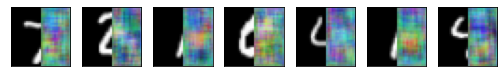

157/157 [==============================] - 30s 194ms/step - d_loss: 2.1416 - g_loss: -0.4666 - gp: 0.2224 - d_cost: -0.0822
Epoch 58/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0825 - g_loss: -0.4653 - gp: 0.2164 - d_cost: -0.0819epoch 57


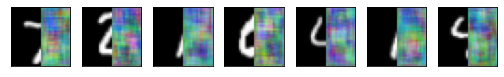

157/157 [==============================] - 30s 194ms/step - d_loss: 2.0858 - g_loss: -0.4651 - gp: 0.2167 - d_cost: -0.0817
Epoch 59/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1174 - g_loss: -0.4641 - gp: 0.2199 - d_cost: -0.0818epoch 58


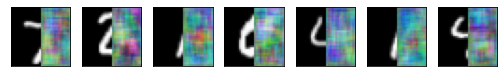

157/157 [==============================] - 31s 194ms/step - d_loss: 2.1160 - g_loss: -0.4641 - gp: 0.2198 - d_cost: -0.0819
Epoch 60/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1196 - g_loss: -0.4634 - gp: 0.2204 - d_cost: -0.0842epoch 59


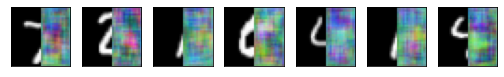

157/157 [==============================] - 31s 195ms/step - d_loss: 2.1181 - g_loss: -0.4631 - gp: 0.2202 - d_cost: -0.0843
Epoch 61/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1618 - g_loss: -0.4623 - gp: 0.2247 - d_cost: -0.0850epoch 60


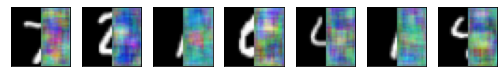

157/157 [==============================] - 30s 194ms/step - d_loss: 2.1653 - g_loss: -0.4622 - gp: 0.2250 - d_cost: -0.0847
Epoch 62/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1357 - g_loss: -0.4635 - gp: 0.2221 - d_cost: -0.0856epoch 61


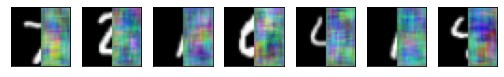

157/157 [==============================] - 31s 194ms/step - d_loss: 2.1364 - g_loss: -0.4635 - gp: 0.2222 - d_cost: -0.0858
Epoch 63/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1268 - g_loss: -0.4595 - gp: 0.2212 - d_cost: -0.0857epoch 62


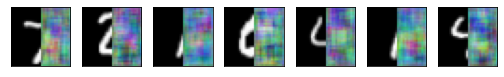

157/157 [==============================] - 30s 193ms/step - d_loss: 2.1179 - g_loss: -0.4591 - gp: 0.2204 - d_cost: -0.0856
Epoch 64/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0925 - g_loss: -0.4591 - gp: 0.2180 - d_cost: -0.0877epoch 63


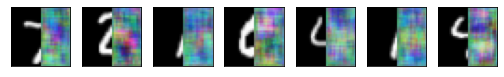

157/157 [==============================] - 30s 194ms/step - d_loss: 2.0842 - g_loss: -0.4588 - gp: 0.2172 - d_cost: -0.0878
Epoch 65/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1288 - g_loss: -0.4611 - gp: 0.2213 - d_cost: -0.0840epoch 64


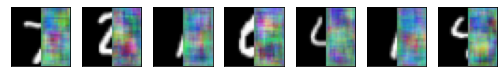

157/157 [==============================] - 31s 196ms/step - d_loss: 2.1300 - g_loss: -0.4609 - gp: 0.2214 - d_cost: -0.0838
Epoch 66/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0978 - g_loss: -0.4589 - gp: 0.2185 - d_cost: -0.0872epoch 65


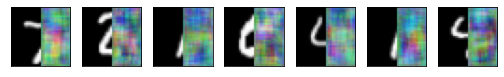

157/157 [==============================] - 31s 194ms/step - d_loss: 2.0972 - g_loss: -0.4589 - gp: 0.2184 - d_cost: -0.0872
Epoch 67/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1129 - g_loss: -0.4577 - gp: 0.2204 - d_cost: -0.0914epoch 66


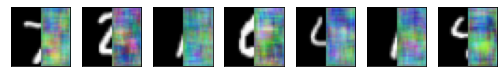

157/157 [==============================] - 30s 194ms/step - d_loss: 2.1130 - g_loss: -0.4575 - gp: 0.2204 - d_cost: -0.0912
Epoch 68/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1361 - g_loss: -0.4570 - gp: 0.2228 - d_cost: -0.0924epoch 67


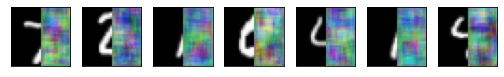

157/157 [==============================] - 31s 194ms/step - d_loss: 2.1406 - g_loss: -0.4570 - gp: 0.2233 - d_cost: -0.0921
Epoch 69/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0850 - g_loss: -0.4578 - gp: 0.2178 - d_cost: -0.0931epoch 68


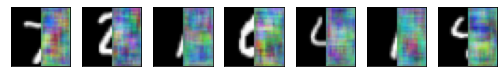

157/157 [==============================] - 30s 194ms/step - d_loss: 2.0828 - g_loss: -0.4577 - gp: 0.2176 - d_cost: -0.0931
Epoch 70/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0706 - g_loss: -0.4583 - gp: 0.2162 - d_cost: -0.0916epoch 69


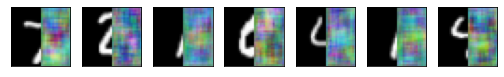

157/157 [==============================] - 31s 195ms/step - d_loss: 2.0663 - g_loss: -0.4586 - gp: 0.2158 - d_cost: -0.0914
Epoch 71/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1093 - g_loss: -0.4575 - gp: 0.2203 - d_cost: -0.0937epoch 70


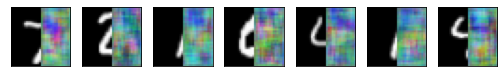

157/157 [==============================] - 30s 194ms/step - d_loss: 2.1038 - g_loss: -0.4576 - gp: 0.2198 - d_cost: -0.0940
Epoch 72/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1183 - g_loss: -0.4566 - gp: 0.2210 - d_cost: -0.0914epoch 71


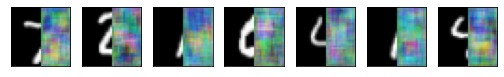

157/157 [==============================] - 31s 195ms/step - d_loss: 2.1121 - g_loss: -0.4566 - gp: 0.2204 - d_cost: -0.0914
Epoch 73/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0664 - g_loss: -0.4550 - gp: 0.2164 - d_cost: -0.0976epoch 72


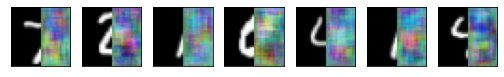

157/157 [==============================] - 30s 194ms/step - d_loss: 2.0619 - g_loss: -0.4549 - gp: 0.2160 - d_cost: -0.0980
Epoch 74/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1107 - g_loss: -0.4543 - gp: 0.2205 - d_cost: -0.0942epoch 73


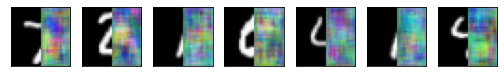

157/157 [==============================] - 31s 194ms/step - d_loss: 2.1095 - g_loss: -0.4542 - gp: 0.2204 - d_cost: -0.0940
Epoch 75/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0714 - g_loss: -0.4544 - gp: 0.2168 - d_cost: -0.0966epoch 74


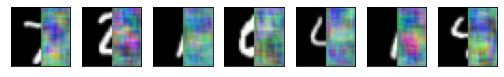

157/157 [==============================] - 30s 194ms/step - d_loss: 2.0709 - g_loss: -0.4545 - gp: 0.2168 - d_cost: -0.0970
Epoch 76/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0703 - g_loss: -0.4513 - gp: 0.2168 - d_cost: -0.0977epoch 75


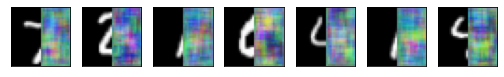

157/157 [==============================] - 31s 196ms/step - d_loss: 2.0653 - g_loss: -0.4511 - gp: 0.2162 - d_cost: -0.0968
Epoch 77/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0518 - g_loss: -0.4506 - gp: 0.2147 - d_cost: -0.0951epoch 76


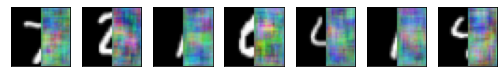

157/157 [==============================] - 31s 194ms/step - d_loss: 2.0506 - g_loss: -0.4505 - gp: 0.2145 - d_cost: -0.0947
Epoch 78/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1007 - g_loss: -0.4516 - gp: 0.2198 - d_cost: -0.0969epoch 77


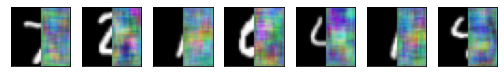

157/157 [==============================] - 31s 194ms/step - d_loss: 2.0999 - g_loss: -0.4516 - gp: 0.2197 - d_cost: -0.0970
Epoch 79/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1167 - g_loss: -0.4490 - gp: 0.2217 - d_cost: -0.1004epoch 78


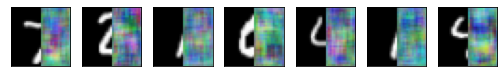

157/157 [==============================] - 31s 195ms/step - d_loss: 2.1174 - g_loss: -0.4489 - gp: 0.2218 - d_cost: -0.1005
Epoch 80/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0033 - g_loss: -0.4489 - gp: 0.2103 - d_cost: -0.0999epoch 79


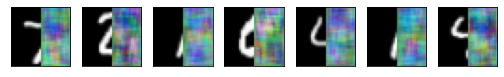

157/157 [==============================] - 31s 194ms/step - d_loss: 1.9961 - g_loss: -0.4488 - gp: 0.2096 - d_cost: -0.0999
Epoch 81/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0591 - g_loss: -0.4492 - gp: 0.2162 - d_cost: -0.1028epoch 80


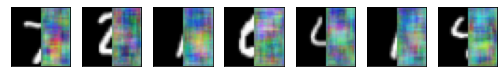

157/157 [==============================] - 31s 195ms/step - d_loss: 2.0535 - g_loss: -0.4492 - gp: 0.2156 - d_cost: -0.1026
Epoch 82/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0567 - g_loss: -0.4495 - gp: 0.2161 - d_cost: -0.1044epoch 81


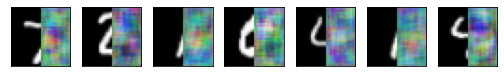

157/157 [==============================] - 31s 195ms/step - d_loss: 2.0548 - g_loss: -0.4498 - gp: 0.2159 - d_cost: -0.1045
Epoch 83/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0658 - g_loss: -0.4487 - gp: 0.2166 - d_cost: -0.1006epoch 82


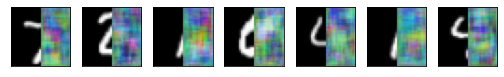

157/157 [==============================] - 30s 194ms/step - d_loss: 2.0673 - g_loss: -0.4486 - gp: 0.2168 - d_cost: -0.1006
Epoch 84/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0359 - g_loss: -0.4476 - gp: 0.2142 - d_cost: -0.1058epoch 83


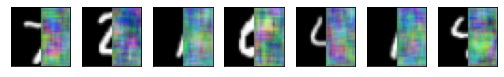

157/157 [==============================] - 31s 194ms/step - d_loss: 2.0299 - g_loss: -0.4477 - gp: 0.2135 - d_cost: -0.1055
Epoch 85/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0361 - g_loss: -0.4481 - gp: 0.2142 - d_cost: -0.1057epoch 84


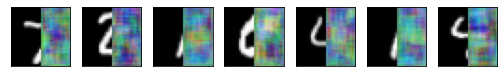

157/157 [==============================] - 30s 194ms/step - d_loss: 2.0401 - g_loss: -0.4480 - gp: 0.2145 - d_cost: -0.1054
Epoch 86/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0732 - g_loss: -0.4478 - gp: 0.2177 - d_cost: -0.1041epoch 85


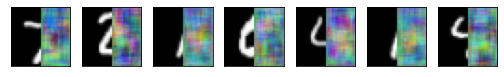

157/157 [==============================] - 31s 195ms/step - d_loss: 2.0691 - g_loss: -0.4479 - gp: 0.2173 - d_cost: -0.1042
Epoch 87/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0831 - g_loss: -0.4463 - gp: 0.2189 - d_cost: -0.1056epoch 86


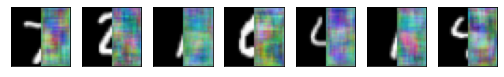

157/157 [==============================] - 31s 195ms/step - d_loss: 2.0737 - g_loss: -0.4461 - gp: 0.2179 - d_cost: -0.1055
Epoch 88/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0527 - g_loss: -0.4456 - gp: 0.2162 - d_cost: -0.1091epoch 87


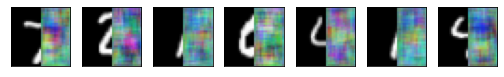

157/157 [==============================] - 30s 193ms/step - d_loss: 2.0481 - g_loss: -0.4453 - gp: 0.2157 - d_cost: -0.1090
Epoch 89/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0320 - g_loss: -0.4468 - gp: 0.2141 - d_cost: -0.1085epoch 88


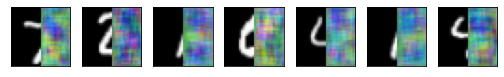

157/157 [==============================] - 31s 195ms/step - d_loss: 2.0284 - g_loss: -0.4471 - gp: 0.2137 - d_cost: -0.1090
Epoch 90/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0111 - g_loss: -0.4457 - gp: 0.2122 - d_cost: -0.1107epoch 89


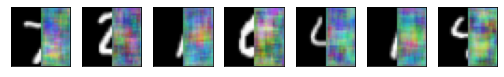

157/157 [==============================] - 30s 194ms/step - d_loss: 2.0004 - g_loss: -0.4458 - gp: 0.2112 - d_cost: -0.1111
Epoch 91/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0133 - g_loss: -0.4443 - gp: 0.2119 - d_cost: -0.1059epoch 90


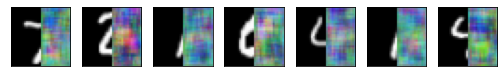

157/157 [==============================] - 30s 193ms/step - d_loss: 2.0176 - g_loss: -0.4438 - gp: 0.2123 - d_cost: -0.1057
Epoch 92/100
157/157 [==============================] - ETA: 0s - d_loss: 2.1013 - g_loss: -0.4449 - gp: 0.2212 - d_cost: -0.1109epoch 91


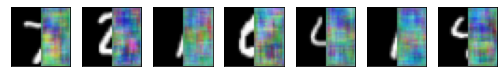

157/157 [==============================] - 31s 195ms/step - d_loss: 2.1033 - g_loss: -0.4448 - gp: 0.2214 - d_cost: -0.1112
Epoch 93/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0545 - g_loss: -0.4436 - gp: 0.2164 - d_cost: -0.1093epoch 92


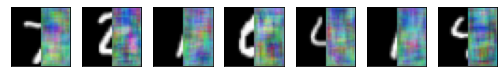

157/157 [==============================] - 30s 194ms/step - d_loss: 2.0584 - g_loss: -0.4437 - gp: 0.2167 - d_cost: -0.1091
Epoch 94/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0808 - g_loss: -0.4433 - gp: 0.2191 - d_cost: -0.1100epoch 93


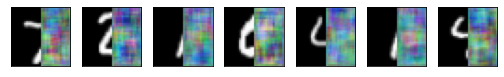

157/157 [==============================] - 31s 194ms/step - d_loss: 2.0819 - g_loss: -0.4429 - gp: 0.2191 - d_cost: -0.1095
Epoch 95/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0918 - g_loss: -0.4425 - gp: 0.2206 - d_cost: -0.1145epoch 94


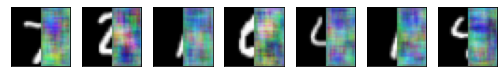

157/157 [==============================] - 31s 195ms/step - d_loss: 2.0951 - g_loss: -0.4424 - gp: 0.2210 - d_cost: -0.1146
Epoch 96/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0696 - g_loss: -0.4422 - gp: 0.2185 - d_cost: -0.1153epoch 95


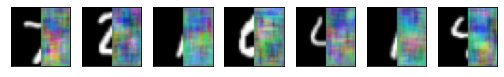

157/157 [==============================] - 31s 194ms/step - d_loss: 2.0608 - g_loss: -0.4423 - gp: 0.2177 - d_cost: -0.1157
Epoch 97/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0630 - g_loss: -0.4413 - gp: 0.2181 - d_cost: -0.1175epoch 96


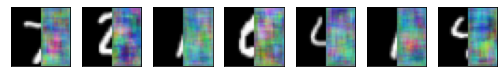

157/157 [==============================] - 31s 196ms/step - d_loss: 2.0605 - g_loss: -0.4417 - gp: 0.2178 - d_cost: -0.1175
Epoch 98/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0661 - g_loss: -0.4409 - gp: 0.2179 - d_cost: -0.1133epoch 97


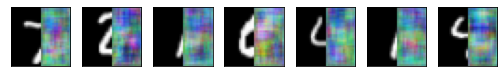

157/157 [==============================] - 30s 193ms/step - d_loss: 2.0662 - g_loss: -0.4408 - gp: 0.2180 - d_cost: -0.1135
Epoch 99/100
157/157 [==============================] - ETA: 0s - d_loss: 2.0593 - g_loss: -0.4377 - gp: 0.2175 - d_cost: -0.1155epoch 98


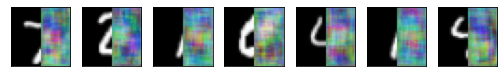

157/157 [==============================] - 30s 194ms/step - d_loss: 2.0589 - g_loss: -0.4376 - gp: 0.2174 - d_cost: -0.1154
Epoch 100/100
157/157 [==============================] - ETA: 0s - d_loss: 1.9928 - g_loss: -0.4390 - gp: 0.2110 - d_cost: -0.1171epoch 99


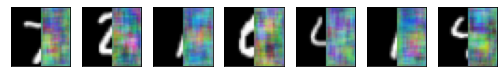

157/157 [==============================] - 31s 194ms/step - d_loss: 1.9818 - g_loss: -0.4393 - gp: 0.2099 - d_cost: -0.1169


In [ ]:
# generator_optimizer = Adam(learning_rate=0.0002*0.1, beta_1=0.5, beta_2=0.9)
# discriminator_optimizer = Adam(learning_rate=0.0002*0.1, beta_1=0.5, beta_2=0.9)
generator_optimizer = Adam(learning_rate=0.0001*0.0001)
discriminator_optimizer = Adam(learning_rate=0.0001*0.0001)


def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean((real_img+1e-9))
    fake_loss = tf.reduce_mean((fake_img+1e-9))
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

g_model = get_generator_model()
d_model = get_discriminator_model()

wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=LATENT_DIM,
    discriminator_extra_steps=3,
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

cbk = GANMonitor(test_images[:8])
history = wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=100, callbacks=[cbk])
# wgan.fit(train_images[:1000], batch_size=BATCH_SIZE, epochs=2, callbacks=[cbk])